# Transfer function

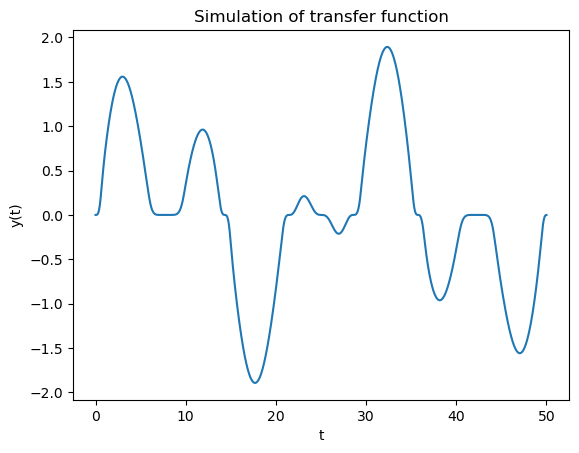

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

dt = 0.01
T = 50
N = int(T / dt)
t = np.linspace(0, T, N)
u = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)

y_k = np.zeros(N)

for k in range(1, N-1):
    y_k[k+1] = y_kp1(y_k[k], y_k[k-1], u[k-1])

plt.plot(t, y_k)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Simulation of transfer function')
plt.show()

# Actor Critic

### Referece model

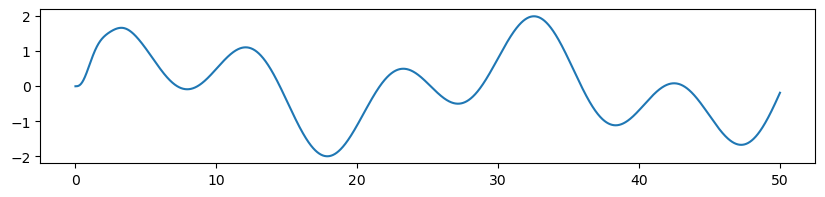

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

w_n = 3.1623
zita = 0.316
K = 1

num = [K]
den = [1/w_n**2, 2*zita/w_n, 1]

transfer_function = ctrl.TransferFunction(num, den)

dt = 0.01
T = 50
N = int(T / dt)
t = np.linspace(0, T, N)
u = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)

resp = ctrl.forced_response(transfer_function, t, u)
t, output, state = resp.time, resp.outputs, resp.states

u = u.reshape([-1,1])
y_m = output.reshape([-1,1])

plt.figure(figsize=(10,2))
plt.plot(t, y_m)

### MLP

In [153]:
class MLP(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Actor Critic

In [244]:
from utils.buffer import ReplayBuffer
from utils.plot import plot_return

batch_size = 5
memory = ReplayBuffer(batch_size)

for i in range(batch_size):
    memory.push([0, 0, 0])

# RBF models
learning_rate = 0.1

observer = MLP(2,5)#RadialBasisFunction(2, 1, 10)#
observer_criterion = nn.MSELoss()
observer_optim = torch.optim.Adam(observer.parameters(), lr=learning_rate/10)

critic = MLP(2,16)#RadialBasisFunction(2, 1, 10)#
critic_criterion = nn.MSELoss()
critic_optim = torch.optim.Adam(critic.parameters(), lr=learning_rate/10)

actor = MLP(3,5)#RadialBasisFunction(3, 1, 10)#
actor_criterion = nn.MSELoss()
actor_optim = torch.optim.Adam(actor.parameters(), lr=learning_rate/1)


def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

loss = []
model_data = []
for i, y_ref in enumerate(y_m):
    u, y_p, y_des = memory.sample(batch_size)
    u, y_p = np.array(u), np.array(y_p)
    
    u_shifted = np.zeros_like(u)
    u_shifted[1:] = u[:-1]

    y_p_shifted = np.zeros_like(y_p)
    y_p_shifted[1:] = y_p[:-1]

    y_ref_array = np.zeros_like(y_p)
    y_ref_array[:] = y_des
    
    # controller input
    cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
    with torch.no_grad(): u_new = actor(cntrl_input)
    u_new = np.array(u_new).ravel()
    y_p_new = y_kp1(y_p, y_p_shifted, u_new)
    model_data.append([y_ref.item(), y_p_new[-1]])
    
    memory.push([u_new[-1], y_p_new[-1], y_ref.item()])
    
    if len(memory) >= batch_size:
        u, y_p, y_des = memory.sample(len(memory))

        u_shifted = np.zeros_like(u)
        u_shifted[1:] = u[:-1]

        y_p_shifted = np.zeros_like(y_p)
        y_p_shifted[1:] = y_p[:-1]

        y_ref_array = np.zeros_like(y_p)
        y_ref_array[:] = y_des
        
        y_ref_shifted = np.zeros_like(y_p)
        y_ref_shifted[1:] = y_des[:-1]


        # update observer
        obs_input = torch.tensor(np.vstack([y_p_shifted, u]).T).to(torch.float32).view(-1,2)
        obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)

        observer_optim.zero_grad()
        y_p_hat = observer(obs_input)
        # print(y_p_hat.shape, obs_label.shape)
        observer_loss = observer_criterion(y_p_hat, obs_label)
        observer_loss.backward()
        observer_optim.step()


        # update critic
        critic_input = torch.tensor(np.vstack([y_p_shifted, y_ref_shifted]).T).to(torch.float32).view(-1,2)
        critic_next_input = torch.tensor(np.vstack([y_p, y_ref_array]).T).to(torch.float32).view(-1,2)
        # obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)

        gamma = 1
        reward = -torch.tensor((y_ref_array-y_p)**2).to(torch.float32).view(-1,1)
        states_val = critic(critic_input)
        next_states_val = critic(critic_next_input)
        value_targets = reward + gamma * next_states_val

        # Compute Value Loss
        value_loss = F.mse_loss(states_val, value_targets.detach())
        # Update Value network
        critic_optim.zero_grad()
        value_loss.backward()
        critic_optim.step()

        critic_optim.zero_grad()
        observer_optim.zero_grad()


        # update actor
        # print(np.shape(y_p_shifted))
        cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
        u_hat = actor(cntrl_input)
        observer_input = torch.stack([torch.tensor(y_p).view(-1,1), u_hat.view(-1,1)]).to(torch.float32).view(-1,2)
        y_p_hat = observer(observer_input)
        # cntrl_label = torch.tensor(y_ref_array).to(torch.float32).view(-1,1)
        # print(y_p_hat.shape)
        # Compute Actor Loss
        # critic_input = torch.tensor(np.vstack([y_p_shifted, y_ref_shifted]).T).to(torch.float32).view(-1,2)
        critic_input = torch.stack([y_p_hat.view(-1,1), torch.tensor(y_ref_array).view(-1,1)]).to(torch.float32).view(-1,2)
        actor_loss = -(reward + critic(critic_input)).mean()#reward + 
        # print(observer_loss.shape, value_loss.shape, actor_loss.shape)
        # Update Actor network
        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()




 
        # # update controller
        # controller_optim.zero_grad()
        # u_hat = controller(cntrl_input)
        # y_p_hat = observer(observer_input)
        # # print(y_p_hat.shape, u_hat.shape)
        # controller_loss = controller_criterion(y_p_hat, cntrl_label)
        # controller_loss.backward()
        # controller_optim.step()
        loss.append(actor_loss.detach().numpy().ravel())
        # plot_return(loss, f'RBF Controller Loss')

        print(f'Observer: {observer_loss} - value: {value_loss} - actor: {actor_loss}')



Observer: 0.04354855418205261 - value: 7.236164947244106e-07 - actor: -0.04715760424733162
Observer: 0.032699406147003174 - value: 5.526478048523131e-07 - actor: 0.006744367070496082
Observer: 0.025738989934325218 - value: 2.4493064643138496e-07 - actor: 0.05825583264231682
Observer: 0.025428850203752518 - value: 1.3651528263380897e-07 - actor: 0.11043895781040192
Observer: 0.03881402313709259 - value: 2.387256608926691e-05 - actor: 0.15326158702373505
Observer: 0.10334718227386475 - value: 0.002819145331159234 - actor: 0.20676341652870178
Observer: 0.2678000330924988 - value: 0.04425903409719467 - actor: 0.32856765389442444
Observer: 0.6243172287940979 - value: 0.3744514584541321 - actor: 0.6075092554092407
Observer: 2.0106613636016846 - value: 8.365290641784668 - actor: 1.8730437755584717
Observer: 9.654480934143066 - value: 270.65679931640625 - actor: 9.042435646057129
Observer: 43.5987434387207 - value: 5779.9833984375 - actor: 41.932716369628906
Observer: 43.91659927368164 - value

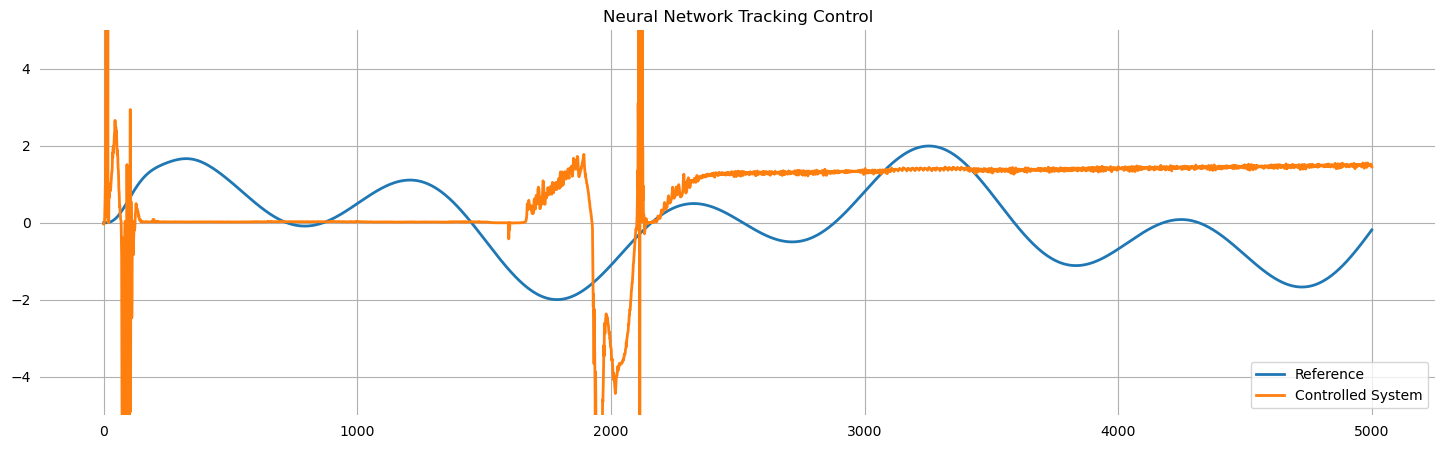

In [245]:
model_data = np.array(model_data)

plt.figure(figsize=(18, 5))
plt.plot(model_data[:, 0], linewidth=2)
plt.plot(model_data[:, 1], linewidth=2)
plt.grid()
plt.title('Neural Network Tracking Control')
plt.legend(['Reference', 'Controlled System'], loc='lower right')
plt.ylim([-5, 5])

# Get current axes
ax = plt.gca()

# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, remove the ticks as well
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Show the plot
plt.show()

# Neural Network Tracking Control

In [ ]:
from utils.buffer import ReplayBuffer
from utils.plot import plot_return

batch_size = 32
memory = ReplayBuffer(batch_size)

for i in range(batch_size):
    memory.push([0, 0, 0])

# RBF models
learning_rate = 0.1

observer = MLP(2,8)#RadialBasisFunction(2, 1, 10)#
observer_criterion = nn.MSELoss()
observer_optim = torch.optim.Adam(observer.parameters(), lr=learning_rate/10)

controller = MLP(3,8)#RadialBasisFunction(3, 1, 10)#
controller_criterion = nn.MSELoss()
controller_optim = torch.optim.Adam(controller.parameters(), lr=learning_rate)

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

loss = []
model_data = []
for i, y_ref in enumerate(y_m):
    u, y_p, y_des = memory.sample(batch_size)
    u, y_p = np.array(u), np.array(y_p)
    
    u_shifted = np.zeros_like(u)
    u_shifted[1:] = u[:-1]

    y_p_shifted = np.zeros_like(y_p)
    y_p_shifted[1:] = y_p[:-1]

    y_ref_array = np.zeros_like(y_p)
    y_ref_array[:] = y_des

    # controller input
    cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
    with torch.no_grad(): u_new = controller(cntrl_input)
    u_new = np.array(u_new).ravel()
    y_p_new = y_kp1(y_p, y_p_shifted, u_new)
    model_data.append([y_ref.item(), y_p_new[-1]])
    
    memory.push([u_new[-1], y_p_new[-1], y_ref.item()])
    
    if len(memory) >= batch_size:
        u, y_p, y_des = memory.sample(len(memory))

        u_shifted = np.zeros_like(u)
        u_shifted[1:] = u[:-1]

        y_p_shifted = np.zeros_like(y_p)
        y_p_shifted[1:] = y_p[:-1]

        y_ref_array = np.zeros_like(y_p)
        y_ref_array[:] = y_des


        obs_input = torch.tensor(np.vstack([y_p_shifted, u]).T).to(torch.float32).view(-1,2)
        obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)

        cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
        cntrl_label = torch.tensor(y_ref_array).to(torch.float32).view(-1,1)

        # update observer
        observer_optim.zero_grad()
        y_p_hat = observer(obs_input)
        # print(y_p_hat.shape, obs_label.shape)
        observer_loss = observer_criterion(y_p_hat, obs_label)
        observer_loss.backward()
        observer_optim.step()

        # update controller
        controller_optim.zero_grad()
        u_hat = controller(cntrl_input)
        obs_input = torch.stack([torch.tensor(y_p_shifted).view(-1,1), u_hat.view(-1,1)]).to(torch.float32).view(-1,2)
        y_p_hat = observer(obs_input)
        # print(y_p_hat.shape, u_hat.shape)
        controller_loss = controller_criterion(y_p_hat, cntrl_label)
        controller_loss.backward()
        controller_optim.step()
        loss.append(controller_loss.detach().numpy().ravel())
        # plot_return(loss, f'RBF Controller Loss')

        print(f'Observer: {observer_loss} - Controller: {controller_loss}')



Observer: 0.003510660957545042 - Controller: 0.001024029217660427
Observer: 0.001345740631222725 - Controller: 8.615694241598248e-05
Observer: 0.0004249391204211861 - Controller: 0.00041428254917263985
Observer: 0.00021921016741544008 - Controller: 0.0011901193065568805
Observer: 0.0005482857231982052 - Controller: 0.001744538196362555
Observer: 0.0009459775174036622 - Controller: 0.001796640339307487
Observer: 0.0011831645388156176 - Controller: 0.0011760059278458357
Observer: 0.0011488667223602533 - Controller: 0.0005435002385638654
Observer: 0.00093295075930655 - Controller: 0.001557361101731658
Observer: 0.0006133161950856447 - Controller: 0.0011923351557925344
Observer: 0.0003571996930986643 - Controller: 0.00044268261990509927
Observer: 0.00020929903257638216 - Controller: 8.954625081969425e-05
Observer: 0.0002233065606560558 - Controller: 4.716424518846907e-05
Observer: 0.0003627666155807674 - Controller: 7.057344191707671e-05
Observer: 0.0004573316255118698 - Controller: 9.9707

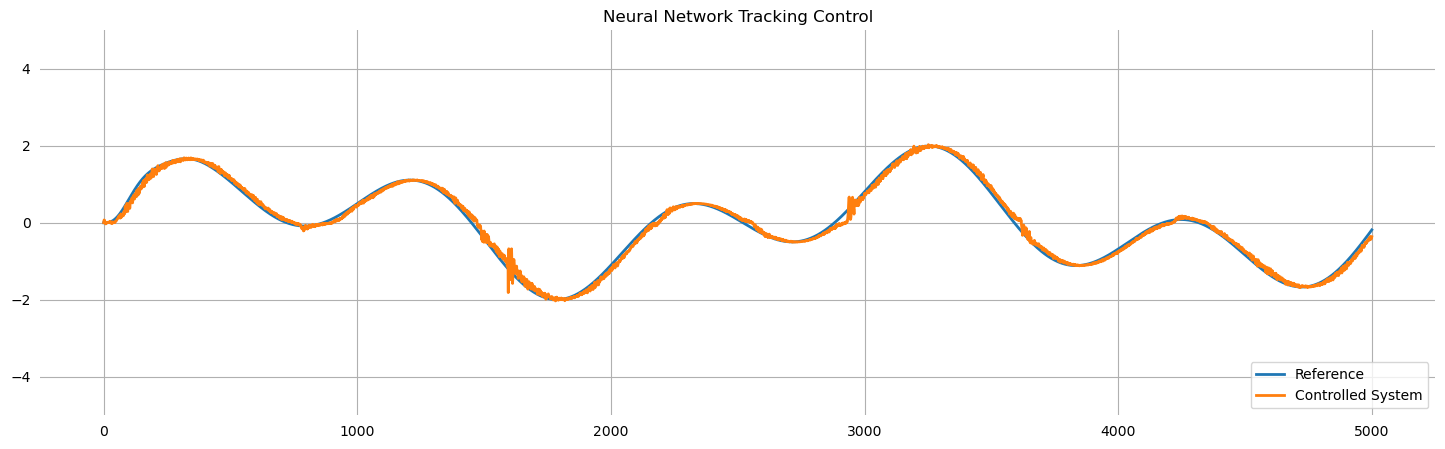

In [ ]:
model_data = np.array(model_data)

plt.figure(figsize=(18, 5))
plt.plot(model_data[:, 0], linewidth=2)
plt.plot(model_data[:, 1], linewidth=2)
plt.grid()
plt.title('Neural Network Tracking Control')
plt.legend(['Reference', 'Controlled System'], loc='lower right')
plt.ylim([-5, 5])

# Get current axes
ax = plt.gca()

# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, remove the ticks as well
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Show the plot
plt.show()

### RBF

In [ ]:
from utils.buffer import ReplayBuffer
from utils.plot import plot_return

batch_size = 32
memory = ReplayBuffer(batch_size)

for i in range(batch_size):
    memory.push([0, 0])

# RBF models
learning_rate = 0.1

observer = RadialBasisFunction(2, 1, 5)#
observer_criterion = nn.MSELoss()
observer_optim = torch.optim.Adam(observer.parameters(), lr=learning_rate/5)

controller = RadialBasisFunction(3, 1, 5)#
controller_criterion = nn.MSELoss()
controller_optim = torch.optim.Adam(controller.parameters(), lr=learning_rate)

def y_kp1(y_k, y_km1, u_k):
    return (y_k * y_km1 * u_k + u_k**3 + 0.5 * y_km1) / (1 + y_k**2 + y_km1**2)

loss = []
model_data = []
for i, y_ref in enumerate(y_m[:2000]):
    u, y_p = memory.sample(batch_size)
    u, y_p = np.array(u), np.array(y_p)
    
    u_shifted = np.zeros_like(u)
    u_shifted[1:] = u[:-1]

    y_p_shifted = np.zeros_like(y_p)
    y_p_shifted[1:] = y_p[:-1]

    y_ref_array = np.zeros_like(y_p)
    y_ref_array[:] = y_ref
    
    # controller input
    cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
    with torch.no_grad(): u_new = controller(cntrl_input)
    u_new = np.array(u_new).ravel()
    y_p_new = y_kp1(y_p, y_p_shifted, u_new)
    model_data.append([y_ref[-1], y_p_new[-1]])
    
    memory.push([u_new[-1], y_p_new[-1]])
    
    if len(memory) >= batch_size:
        u, y_p = memory.sample(len(memory))

        u_shifted = np.zeros_like(u)
        u_shifted[1:] = u[:-1]

        y_p_shifted = np.zeros_like(y_p)
        y_p_shifted[1:] = y_p[:-1]

        y_ref_array = np.zeros_like(y_p)
        y_ref_array[:] = y_ref

        obs_input = torch.tensor(np.vstack([y_p_shifted, u]).T).to(torch.float32).view(-1,2)
        obs_label = torch.tensor(y_p).to(torch.float32).view(-1,1)

        cntrl_input = torch.tensor(np.vstack([y_ref_array, y_p, u]).T).to(torch.float32).view(-1,3)
        cntrl_label = torch.tensor(y_ref_array).to(torch.float32).view(-1,1)

        # update observer
        observer_optim.zero_grad()
        y_p_hat = observer(obs_input)
        # print(y_p_hat.shape, obs_label.shape)
        observer_loss = observer_criterion(y_p_hat, obs_label)
        observer_loss.backward()
        observer_optim.step()

        # update controller
        controller_optim.zero_grad()
        u_hat = controller(cntrl_input)
        observer_input = torch.stack([torch.tensor(y_p_shifted).view(-1,1), u_hat.view(-1,1)]).to(torch.float32).view(-1,2)
        y_p_hat = observer(observer_input)
        # print(y_p_hat.shape, u_hat.shape)
        controller_loss = controller_criterion(y_p_hat, cntrl_label)
        controller_loss.backward()
        controller_optim.step()
        loss.append(controller_loss.detach().numpy().ravel())
        # plot_return(loss, f'RBF Controller Loss')

        print(f'Observer: {observer_loss} - Controller: {controller_loss}')



NameError: name 'RadialBasisFunction' is not defined

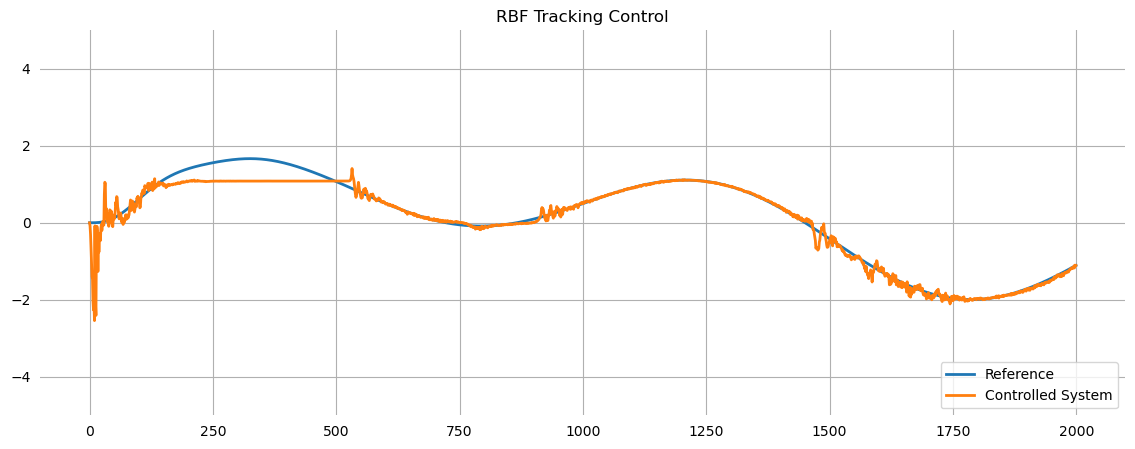

In [ ]:
model_data = np.array(model_data)

plt.figure(figsize=(14, 5))
plt.plot(model_data[:, 0], linewidth=2)
plt.plot(model_data[:, 1], linewidth=2)
plt.grid()
plt.title('RBF Tracking Control')
plt.legend(['Reference', 'Controlled System'], loc='lower right')
plt.ylim([-5, 5])

# Get current axes
ax = plt.gca()

# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Optionally, remove the ticks as well
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Show the plot
plt.show()